In [0]:
from __future__ import print_function
import numpy as np

import keras
from keras.datasets import cifar10
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Model
import os

from sklearn.model_selection import train_test_split

Mixup Augmentation

In [0]:



class MixupAugmentation():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.4, shuffle=True):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
      

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)


        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

RESNET20

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

 

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape, depth, num_classes=10):
    
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


Data Preparation

In [0]:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

input_shape = x_train.shape[1:]

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train, X_test, y_train, Y_test = train_test_split(x_train, y_train, stratify=y_train, test_size=0.8)

N = 10

y_train = keras.utils.to_categorical(y_train, N)
y_test = keras.utils.to_categorical(y_test, N)

Training Parameters

In [0]:
batch_size = 128 
epochs = 100
#N = 10

n=3
depth = n*6+2
model_type = 'ResNet%dv' % (depth)

Model

In [18]:
model = resnet_v2(input_shape=input_shape, depth=depth)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

#Augmentation
mixup_generator = MixupAugmentation(x_train, y_train, batch_size=batch_size, alpha=0.4)()

plot = model.fit_generator(generator=mixup_generator,
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1
                        )

#Final Scores
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/100
78/78 [==============================] - 17s 216ms/step - loss: 2.3881 - accuracy: 0.3122 - val_loss: 2.8209 - val_accuracy: 0.1984
Epoch 2/100
78/78 [==============================] - 7s 87ms/step - loss: 2.1216 - accuracy: 0.4231 - val_loss: 2.9241 - val_accuracy: 0.1984
Epoch 3/100
78/78 [==============================] - 7s 87ms/step - loss: 1.9744 - accuracy: 0.4958 - val_loss: 2.6703 - val_accuracy: 0.2101
Epoch 4/100
78/78 [==============================] - 7s 86ms/step - loss: 1.8678 - accuracy: 0.5392 - val_loss: 2.4910 - val_accuracy: 0.2800
Epoch 5/100
78/78 [==============================] - 7s 87ms/step - loss: 1.7730 - accuracy: 0.5782 - val_loss: 1.8175 - val_accuracy: 0.4676
Epoch 6/100
78/78 [==============================] - 7s 87ms/step - loss: 1.6939 - accuracy: 0.6143 - val_loss: 1.9808 - val_accuracy: 0.4264
Epoch 7/100
78/78 [==============================] - 7s 87ms/step - loss: 1.6353 - accuracy: 0.6327 - val_loss: 1.8311 - val_accuracy: 0.4695
Epoc

Plot : Accuracy

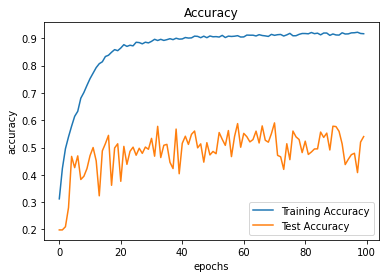

In [19]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(plot.history['accuracy'], label='Training Accuracy')
plt.plot(plot.history['val_accuracy'], label='Test Accuracy')
#plt.plot(plot.history['loss'], label='Training Loss')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

Plot : Loss

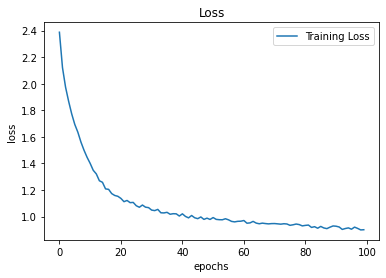

In [20]:
plt.plot(plot.history['loss'], label='Training Loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()